In [1]:
%pylab inline
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.externals.joblib import delayed, Parallel
from dask_ml.wrappers import ParallelPostFit
from models import make_voting_ensemble
from predict import preprocess_data
from os.path import join as pj
from tqdm import tqdm_notebook
from copy import deepcopy
import pandas as pd

datadir = '/Users/jkyl/Desktop/'
train_df = pd.read_csv(pj(datadir, 'numerai_training_data.csv'))
tourn_df = pd.read_csv(pj(datadir, 'numerai_tournament_data.csv'))
(X, y, eras), _ = preprocess_data(train_df, tourn_df, target='bernie')
ueras = unique(eras)
K = len(ueras)
era_masks = {era: eras==era for era in ueras}

Populating the interactive namespace from numpy and matplotlib


In [2]:
Cs = geomspace(1e-4, 1e2, 7)
fits = empty((len(ueras), len(Cs)), dtype=object)
model = LogisticRegression(tol=1e-4, max_iter=1000, warm_start=True)
for i, train_era in enumerate(tqdm_notebook(ueras)):
    train_mask = era_masks[train_era]
    X_train, y_train = X[train_mask], y[train_mask]
    for j, C in enumerate(Cs):
        model.set_params(C=C)
        model.fit(X_train, y_train)
        fits[i, j] = deepcopy(model)

HBox(children=(IntProgress(value=0, max=132), HTML(value='')))

In [ ]:
random.seed(1017)
min_loss = inf
cv_losses = empty(K)
probs = empty(len(X))
for epoch in tqdm_notebook(range(5000)):
    sample = random.randint(len(Cs), size=K)
    learners = [fits[i, j] for i, j in enumerate(sample)]
    ensemble = make_voting_ensemble(learners, -1)
    probs[:] = ensemble.predict_proba(X)[:, 1]
    for k, val_era in enumerate(ueras):
        val_mask = era_masks[val_era]
        train_probs = learners[k].predict_proba(X[val_mask])[:, 1]
        cv_probs = ((K * probs[val_mask]) - train_probs) / (K - 1)
        cv_loss = log_loss(y[val_mask], cv_probs)
        cv_losses[k] = cv_loss
    loss = mean(cv_losses)
    if loss < min_loss:
        min_loss = loss
        min_sample = sample()
        print(min_loss)

In [ ]:
save('/Users/jkyl/Desktop/min_sample.npy', min_sample)

In [21]:
random.seed(420)
#sys.setrecursionlimit(1000)
#memory = {}
def evaluate(sample):
    if tuple(sample) in memory:
        return memory[tuple(sample)]
    learners = [fits[i, j] for i, j in enumerate(sample)]
    ensemble = make_voting_ensemble(learners, -1)
    probs = ensemble.predict_proba(X)[:, 1]
    cv_losses = empty(K)
    for k, val_era in enumerate(ueras):
        val_mask = era_masks[val_era]
        train_probs = learners[k].predict_proba(X[val_mask])[:, 1]
        cv_probs = ((K * probs[val_mask]) - train_probs) / (K - 1)
        cv_loss = log_loss(y[val_mask], cv_probs)
        cv_losses[k] = cv_loss
    loss = mean(cv_losses)
    memory[tuple(sample)] = loss
    return loss

def reproduce(parents, num_children, mutate_prob):
    children = array([parents[0] for _ in range(num_children)])
    for ind in where(parents[0] != parents[1])[0]:
        children[:, ind] = random.choice(parents[:, ind], size=num_children)
    mutate_mask = random.binomial(1, mutate_prob, size=children.shape).astype(bool)
    if mutate_mask.sum():
        children[mutate_mask] = random.randint(len(Cs), size=mutate_mask.sum())
    if len(set(map(tuple, children)).union(set(map(tuple, parents)))) < num_children + 2:
        return reproduce(parents, num_children, mutate_prob)
    return children
    
def genetic_search(population_size=10, num_children=2, generations=100, mutate_prob=1e-3):
    population = random.randint(len(Cs), size=(population_size, K)).tolist()
    min_loss = inf
    for generation in tqdm_notebook(range(generations)):
        loss = array([evaluate(i) for i in population])
        if loss.min() < min_loss:
            min_loss = loss.min()
            print(min_loss)
        fitness = loss.max() - loss
        fitness /= fitness.max()
        fitness /= fitness.sum()
        parent_inds = random.choice(population_size, size=2, p=fitness, replace=False)
        parents = array(population)[parent_inds]
        while all(parents[0]==parents[1]):
            parent_inds = random.choice(population_size, size=2, p=fitness, replace=False)
            parents = array(population)[parent_inds]
        children = reproduce(parents, num_children, mutate_prob)
        population += children.tolist()
        population.pop(argmin(fitness))
        population_size += num_children - 1
    return population[:-num_children], loss

population, losses = genetic_search(
    population_size=10, 
    num_children=1, 
    generations=3050, 
    mutate_prob=.01
)

HBox(children=(IntProgress(value=0, max=3050), HTML(value='')))

0.692693768755076
0.6926785749216223
0.6926742910235727
0.6926556561914843
0.6926337744567315
0.6926328122292481
0.6926280079558632
0.6926248047731385
0.692617116237998
0.6926088503522079
0.6926026337939301
0.6925971477546741
0.6925961371005707
0.6925955508238203
0.6925954710432153
0.6925932524401944
0.6925895184015406
0.6925882157180749
0.69258741781885
0.6925805805080152
0.6925781039878689
0.6925765705838719
0.6925739405649783
0.6925724236548088
0.6925720543088248
0.6925684143986856
0.6925666292403341
0.692565740599441
0.6925630229485095
0.6925621454621773
0.692559052001246
0.6925580898931781
0.6925572309072023
0.6925554214750864
0.6925541537657918
0.6925530536416027
0.6925517799592822
0.6925505824991145
0.6925468193523376
0.6925456779025422
0.6925389911426678
0.6925383422761494
0.6925357134598418
0.6925355497361719
0.6925348704262059
0.6925324125800328
0.6925316403818447
0.6925309057310609
0.6925307306363062
0.6925305457065454
0.6925294325164258
0.692528156333474
0.6925237046880883


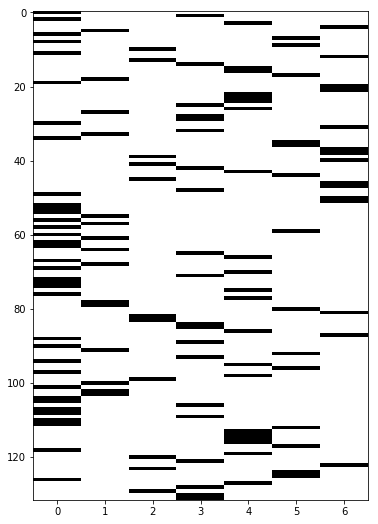

In [22]:
figure(figsize=(6, 9))
imshow(eye(7)[(population[argmin(losses)])], cmap='gray_r')

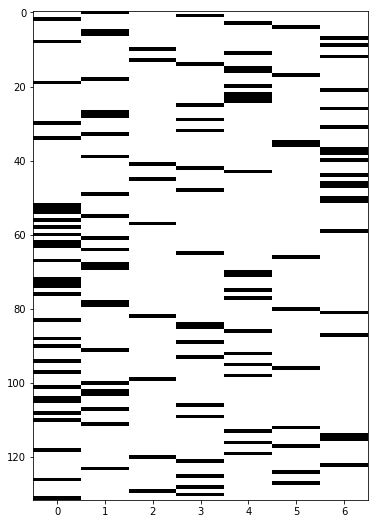

In [19]:
figure(figsize=(6, 9))
imshow(eye(7)[(population[argmin(losses)])], cmap='gray_r')